# **RSNA Pneumonia Detection Challenge**
(Final Project for Data Mining in NJIT)

Subitted to:         
**Pantelis Monogioudis**         
(Head of the Applied Machine Learning Department @ Bell Labs. 
Adjunct Prof. @NJIT
                        


---


Submitted by:

*  Atul Avijeet (aa2758@njit.edu)
*  Saurav Harjaii                       
*   Subhasree Kurusamy



---



Kaggle Link of the challenge:
The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

This notebook covers the basics of parsing the competition dataset, training using a detector basd on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.  


This notebook is developed by Atul Avijeet, Saurav Hajrai and Subhasree based upon the kernel by MD.ai., START HERE: Beginner Intro to Lung Opacity S1, RSNA Pneumonia Detection EDA, 	RPN mask r-cnn regions exploration on RSNA data

This notebook requires Google's [TensorFlow](https://www.tensorflow.org/) machine learning framework.


---




Here we will install 3 dependencies, which are not present in Colab.

**Pydicom**

Pydicom is a pure Python package for working with DICOM files such as medical images, reports, and radiotherapy objects.

Pydicom makes it easy to read these complex files into natural pythonic structures for easy manipulation. Modified datasets can be written again to DICOM format files.




** Tqdm**
 
 When dealing with large datasets, even the simplest operations can take hours. Progress bars can help make data processing jobs less of a headache because:
 

1. You get a reliable estimate of how long it will take
.

2. You can see immediately if it’s gotten stuck

.
The first of these is especially valuable in a business environment, where having a solid delivery estimate can make you look super professional. The best/only way I’ve found to add progress bars to Python code is with tqdm.).

**Imaug**

A library for image augmentation in machine learning experiments, particularly convolutional neural networks. Supports the augmentation of images, keypoints/landmarks, bounding boxes, heatmaps and segmentation maps in a variety of different ways.



---



In [1]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 

!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

     |████████████████████████████████| 7.0MB 4.4MB/s 




---

**Importing packages**

Now we will import the requied such as 
os, sys, random, math, numpy, cv2,
matplotlib, json, pydicom, imaguag, tqdm, pandas,
glob and others which are given below.

The following library is used for-


**os**: This module provides a portable way of using operating system dependent functionality. If you just want to read or write a file see open(), if you want to manipulate paths, see the os.path module, and if you want to read all the lines in all the files on the command line see the fileinput module. 

**sys**: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.

**random**: This module implements pseudo-random number generators for various distributions.

**math**: This module is always available. It provides access to the mathematical functions defined by the C standard.


**numpy**: NumPy is the fundamental package for scientific computing with Python. It contains among other things:

a powerful N-dimensional array object
sophisticated (broadcasting) functions
tools for integrating C/C++ and Fortran code
useful linear algebra, Fourier transform, and random number capabilities

**cv2**: Use the function cv2.imread() to read an image. The image should be in the working directory or a full path of image should be given

**matplotlib.pyplot**: matplotlib.pyplot is a collection of command style functions that make matplotlib work like MATLAB. Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc.

**json**: JSON is a syntax for storing and exchanging data.

**pydicom**: Pydicom is a pure Python package for working with DICOM files such as medical images, reports, and radiotherapy objects.


**Imaug**: A library for image augmentation in machine learning experiments, particularly convolutional neural networks. Supports the augmentation of images, keypoints/landmarks, bounding boxes, heatmaps and segmentation maps in a variety of different ways.A library for image augmentation in machine learning experiments, particularly convolutional neural networks. Supports the augmentation of images, keypoints/landmarks, bounding boxes, heatmaps and segmentation maps in a variety of different ways.

**pandas**: pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

**glob** : is a general term used to define techniques to match specified pattern according to rules related Unix shell.

In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

### First: Install Kaggle API for download competition data.


Installation
Ensure you have Python and the package manager pip installed. Run the following command to access the Kaggle API using the command line: pip install kaggle (You may need to do pip install --user kaggle on Mac/Linux. This is recommended if problems come up during the installation process.) Follow the authentication steps below and you’ll be able to use the kaggle CLI tool.

In [0]:
# Install Kaggle API for downloading the competition data
!pip3 install -q kaggle

### Next: Accept the user agreement of the competition website! Then follow [instructions to obtain your Kaggle Credentials.](https://github.com/Kaggle/kaggle-api#api-credentials)  
If you are unable to download the competition dataset, check to see if you have accepted the **user agreement** on the competition website. 

To install the Kaggle API, we will first get the Jason file from going into the Kaggle profile.

After that we will run the kaggle file in another notebook to get the kaggle data and key.


To know your Kaggle Credentials, run this code and upload the jason file. (Since we already have this we will skip this step and mark it as a comment)

from google.colab import files
files.upload()

In [0]:
# enter your Kaggle credentionals here

os.environ['KAGGLE_USERNAME']="aadatamining"
os.environ['KAGGLE_KEY']="08b724d41563013a507bc7cf8652ada5"

Then we will create a root directory of the project and a directory to save the logs and trained model.

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./DataminingProject')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

Now we will download the dataset using Kaggle in colab.

In [6]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 39.2MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 50.8MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 42.2MB/s]
 96% 361M/377M [00:03<00:00, 103MB/s]
100% 377M/377M [00:03<00:00, 108MB/s]
100% 3.28G/3.29G [00:33<00:00, 81.0MB/s]
100% 3.29G/3.29G [00:33<00:00, 107MB/s] 
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 45.1kB/s]


### Download is completed. Now, unzip the test and train datasets as well as the csv of  annotations.

Now we will unzip the required test and train folder. Also the csv annotations.

This will take few minutes to unzip as we have around 30000 files in total.

In [0]:
# unzipping takes a few minutes
!unzip -q -o stage_2_test_images.zip -d stage_2_test_images
!unzip -q -o stage_2_train_images.zip -d stage_2_train_images
!unzip -q -o stage_2_train_labels.csv.zip

###  MD.ai Annotator 
MD.ai was founded by Harvard/Duke/Columbia trained doctors to accelerate the application of AI in medicine with a particular focus on medical imaging. 

**Annotator features**
- The annotator can be used to view DICOM images and create image and exam level annotations.
- You can apply the annotator to filter by label, adjudicate annotations, and assign annotation tasks to your team.
- Notebooks can be built directly within the annotator for rapid model development.
- The data wrangling is abstracted away by the interface and by our MD.ai library.
- Simplifies image annotation in order to widen the participation in the futrue of medical image deep learning.

The annotator allows you to create initial annotations, build and run models, modify/finetune the annotations based on predicted values, and repeat.  
The MD.ai python client library implements functions to easily download images and annotations and to prepare the datasets used to train the model for classification.

###  To install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

This is an implementation of Mask R-CNN on Python 3, Keras, and TensorFlow. The model generates bounding boxes and segmentation masks for each instance of an object in the image. It's based on Feature Pyramid Network (FPN) and a ResNet101 backbone.

To install this we will install this in the root directory and use !git clone link

To clone the Mask RCNN model from github.

In [8]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.70 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (555/555), done.
zip_safe flag not set; analyzing archive contents...


Now import the Mask RCNN in the next step.

In [9]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


**TensorFlow**-
The core open source library to help you develop and train ML models. Get started quickly by running Colab notebooks directly in your browser.

In [0]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

Now since it takes very much time we have to train the deta, hence we will set parameters which helps us to run the code faster, but it is not the optimal solution.

In [12]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

Now in this class, we will use it for the training the pneunomia detection.
Also note we are using the RSNA pneumonia dataset, which we imported from kaggle.
Here add classes and images are added.

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

We will examine the annotation data and then parse the dataset and after that we will view the dicom fields.

In anns, stage_2_train_labels.csv is used.

after that we use anns.head to display 6 patient data.

In [14]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In the next step we will read the dicom image from our file path and then will get the image array.

In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

We will use ds to show the dicom fields.

In [17]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.7974.1517874334.746500
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'f74e692e-1ccd-4f5e-bc19-482325025a41'
(0010, 0020) Patient ID                          LO: 'f74e692e-1ccd-4f5e-bc19-482325025a41'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets
**Note: We have only used only a portion of the images for demonstration purposes. See comments below.**
 
 - To use all the images do: image_fps_list = list(image_fps)
 - Or change the number of images from 100 to a custom number

In [19]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps[:1000]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

900 100


### Create and prepare the training dataset using the DetectorDataset class.

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [21]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    a6148502-53a7-4916-93c1-9fa49c9a953b
 x                                             240
 y                                             436
 width                                         266
 height                                        259
 Target                                          1
 Name: 17359, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

Now here we will display a random image with bounding boxes. 

(1024, 1024, 3)
/content/DataminingProject/stage_2_train_images/78e64e55-99c4-4b43-8695-355ddd50bfef.dcm
[0]


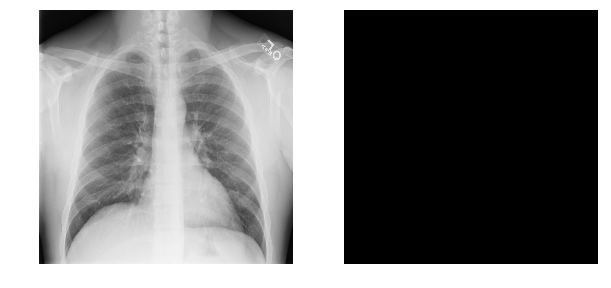

In [23]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [24]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


Note: Warning is about the update of python, so we can ignore that.

### Image Augmentation. Try finetuning some variables to custom values

In [0]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

Now we have to select number of EPOCHS. An average time for 1 EPOCHS is around 18 minutes. 

As said by our Professor, we should select EPOCHS atleast 26. 

Therefore, we are selecting EPOCHS as 30

In [26]:
NUM_EPOCHS = 30

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/DataminingProject/logs/pneumonia20190505T2156/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

**Now we will select trained model.**

In [27]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/DataminingProject/logs/pneumonia20190505T2156/mask_rcnn_pneumonia_0030.h5


In [28]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /content/DataminingProject/logs/pneumonia20190505T2156/mask_rcnn_pneumonia_0030.h5
Re-starting from epoch 30


Now we will set the color for the class

In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained 27 epoch for demonstration purposes.


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



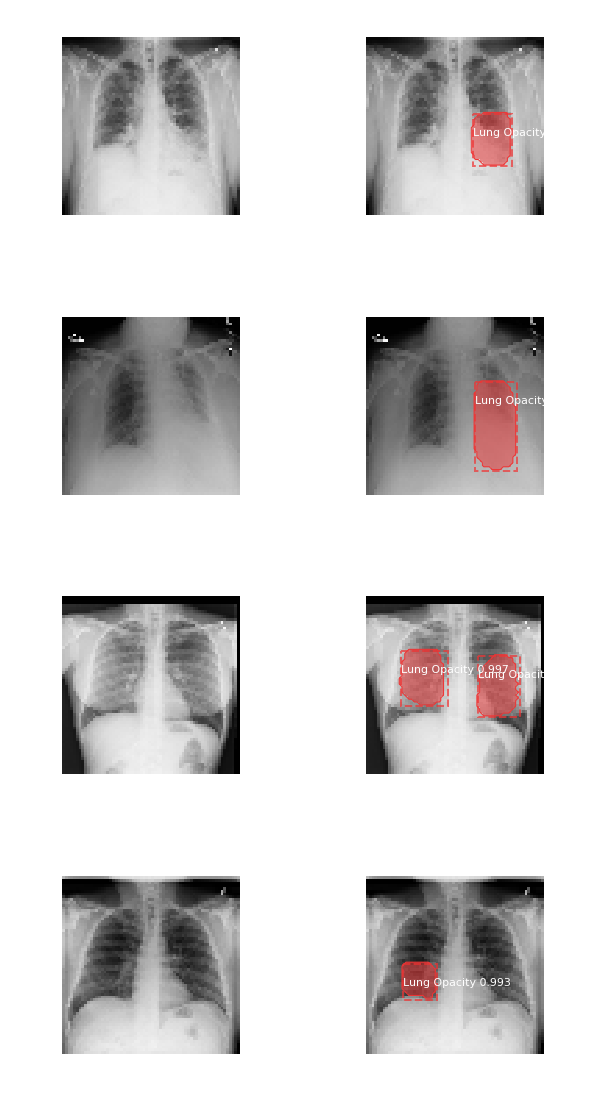

In [30]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

Now we will create the submission file as sample_submission.csv.

In [0]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='sample_submission.csv', min_conf=0.98): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        file.write(out_str+"\n")

Now we will make the final submition in the **sample_submission.csv** file, which will be located in the **content/DataminingProject/Mask_RCNN**

This will take few minutes.

In [33]:
# predict only the first 50 entries
sample_submission_fp = 'sample_submission.csv'
predict(test_image_fps, filepath=sample_submission_fp)

100%|██████████| 3000/3000 [04:30<00:00, 11.39it/s]


**Now we will display the first fifty output as a table. We can select more if you want more in out.head(number)**

In [34]:
output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
output.head(50)

,id,pred_string
0,03e146ff-fd62-4188-9ffa-c61b8f89ac8d,NaN
1,1bae5ce0-3a82-4c56-9c6b-c9d601fb8308,NaN
2,20b0afdd-c8ac-4049-b07f-22b5af366bf6,0.99 254 499 174 335 0.99 671 341 209 512
3,19c61430-be79-4a2b-a888-23f7ef47e5f2,NaN
4,2b2d704b-cb66-4bcc-afb0-4eff225d620d,0.99 177 205 210 433
5,2f27d72f-4e93-482c-b52e-d15db6e66d9a,1.0 646 244 198 408 1.0 176 423 191 195
6,1fe3ad5f-28d1-4d32-a67d-e9ba8188cde7,NaN
7,30e28d63-56f1-46c9-8cd5-42f821342cf1,NaN
8,105b67eb-bf68-4312-b594-cac7d97eed16,NaN
9,1ff10836-3179-4bdb-9c7c-b24acbb4051c,NaN




---


### **Thank you**

---



**Acknowledgements:**

•	Thank you to my Prof. Pantelis Monogioudis, for guiding our project.

•	Thank you to the National Institutes of Health Clinical Center for publicly providing the Chest X-Ray dataset.

•	To original source files and documents.

•	To Google Colab and Stack Overflow.

•	Thanks to Vencent Chen for grading this project.



**References**
•	Kernel: Mask R-CNN for Object Detection and Segmentation on Github- https://github.com/matterport/Mask_RCNN

•	Kernel: START HERE: Beginner Intro to Lung Opacity S1

https://www.kaggle.com/giuliasavorgnan/start-here-beginner-intro-to-lung-opacity-s1

•	Kernel: RSNA Pneumonia Detection EDA-

https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda

•	RPN mask r-cnn regions exploration on RSNA data-    
https://www.kaggle.com/kretes/rpn-mask-r-cnn-regions-exploration-on- rsna-data

•	Google Colab tutorials
